# Integration of Online Learning techniques in ErNESTO

In [170]:
import pandas as pd

This notebook serves as a basis to develop the **parameter adaptation layer** for the DT. <br>
This notebook is strongly connected to the repository. Therefore, this script must be mainteined within the _notebook_ folder of the framework.

## Load real-world data: The experiment is for temp = 20

Right now, we have at disposal two ground dataset:
- **ground_20:** parameters check-up dataset (~32700 samples)
- **ground_PV:** photovoltaic profile dataset (~100000 samples)

<Axes: >

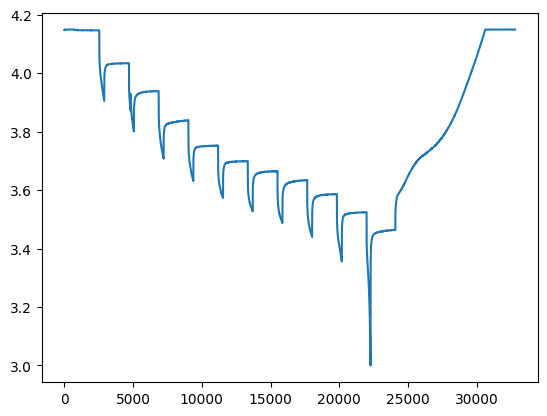

In [171]:
df = pd.read_csv("ground_20.csv")
df['voltage'].plot()

<Axes: >

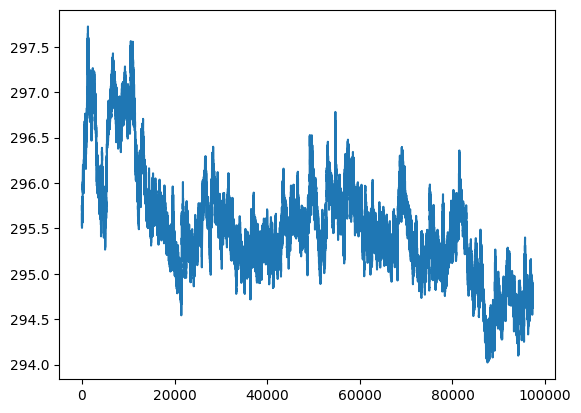

In [172]:
df_pv = pd.read_csv("ground_pv.csv")
df_pv['temperature'].plot()

In [4]:
v_real = df['voltage'].values
i_real = df['current'].values

In [5]:
v_real

array([4.1482, 4.1498, 4.15  , ..., 4.15  , 4.1501, 4.15  ])

## Instantiate the battery model

In [6]:
# data/config/models/electrical/thevenin.yaml 
electrical_params = {
    'type': 'electrical', 
    'class_name': 'TheveninModel', 
    'components': {
        'r0': {
            'selected_type': 'scalar', 
            'scalar': 0.04, 
        }, 
        'r1': {
            'selected_type': 'scalar', 
            'scalar': 0.01, 
        }, 
        'c': {
            'selected_type': 'scalar', 
            'scalar': 10000.0
        }, 
        'v_ocv': {
            'selected_type': 'lookup', 
            'scalar': 3.7,
            'lookup': {
                'inputs': {
                    'soc': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]},
                'output': [3.50066702789707,3.53494897815592,3.56510898252161,3.59331470182294,3.61667561341815,3.63806205584377,3.65277962751219,3.66782635750825,3.68448386705385,3.70214566116145,3.7278881561918,3.75448648951934,3.79678584989904,3.83908521027874,3.88755653595633,3.93607413747301,3.98259785444942,4.02897955883005,4.08245425955629,4.13694678775337, 4.14365] }
            # TODO: HERE YOU HAVE TO PASS A LINK, NOT THE VALUE BY HAND!
                
        }
    }
}

# data/config/models/thermal/r2c_thermal.yaml
thermal_params = {
    'type': 'thermal', 
    'class_name': 'R2CThermal', 
    'components': {
        'c_term': {
            'selected_type': 'scalar', 
            'scalar': 410
        }, 
        'r_cond': {
            'selected_type': 'scalar', 
            'scalar': 0.000784
        }, 
        'r_conv': {
            'selected_type': 'scalar', 
            'scalar': 2.73
        }, 
        'dv_dT': {
            'selected_type': 'lookup', 
            'scalar': 0.1, 
            'lookup': {
                'inputs': {
                    'soc': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]}, 
                'output': [8e-05, 6e-05, 8e-05, 5e-05, 0.0001, 0.00018, 0.00016, 8e-05, -5e-05, -0.00016, -0.0007]}
        }
    }
}

models_config = [electrical_params, thermal_params]

In [7]:
battery_options = {
    'sign_convention': 'passive', 
    'params': {
        'nominal_capacity': 20.0, 
        'v_max': 4.15, 
        'v_min': 3.0, 
        'temp_ambient': 295.15
    }, 
    'init': {
        'voltage': 3.76, 
        'current': 0.0, 
        'temperature': 295.15, 
        'soc': 0.66, 
        'soh': 1.0
    }
}

In [8]:
from src.digital_twin.bess import BatteryEnergyStorageSystem

In [9]:
load_var = 'current'

In [17]:
battery = BatteryEnergyStorageSystem(
    models_config=models_config,
    battery_options=battery_options,
    input_var=load_var
)

[model.name for model in battery.models]

['Thevenin', 'R2C_thermal']

In [23]:
reset_info = {key: electrical_params['components'][key]['scalar'] for key in electrical_params['components'].keys()} 
battery.reset(electrical_params) 
battery.init()

In [24]:
#battery.build_results_table()['operations']['V_rc']
pd.DataFrame.from_dict(battery.build_results_table())
# TODO: CHECK THE UPDATED VALUE !

{'time': [-1], 'soc': [0.66], 'soh': [1.0], 'voltage': [3.76], 'current': [0], 'power': [0.0], 'Vocv': [0], 'R0': [0.04], 'R1': [0.01], 'C': [10000.0], 'V_rc': [0], 'V_r0': [0], 'temperature': [295.15], 'heat': [0]}


operations  aging
time              [-1]    NaN
soc             [0.66]    NaN
soh              [1.0]    NaN
voltage         [3.76]    NaN
current            [0]    NaN
power            [0.0]    NaN
Vocv               [0]    NaN
R0              [0.04]    NaN
R1              [0.01]    NaN
C            [10000.0]    NaN
V_rc               [0]    NaN
V_r0               [0]    NaN
temperature   [295.15]    NaN
heat               [0]    NaN

In [25]:
def update_settings(battery, battery_options, k):
    battery_options['init']['soc'] = battery.soc_series[-1] 
    battery_options['init']['temperature'] = battery._thermal_model.get_temp_series(k)
    battery_options['init']['current'] = battery._electrical_model.get_v_series(k)
    battery_options['init']['voltage'] = battery._electrical_model.get_i_series(k)  

In [62]:
def update_electrical_params(theta, models_config):
    # 0 stands for electrical_params
    models_config[0]['r0'] = theta[0]
    models_config[0]['r1'] = theta[1]
    models_config[0]['c'] = theta[2]

In [29]:
grid_parameters = {
  'soc_interval_one': (0.00, 0.50),
  'soc_interval_two': (0.50, 1.00),
  'temp_interval_one': (283.15, 293.15),
  'temp_interval_two': (293.15, 303.15)
}

In [30]:
class Grid:
    def __init__(self, grid_parameters, soc, temp):
        self.grid_parameters = grid_parameters
        self.cells = self.__generate_cells()
        self._current_cell = None
        self.__check_cell(soc, temp)

    @property
    def current_cell(self):
        return self._current_cell

    def __generate_cells(self):
        cells = {}
        soc_intervals = []
        temp_intervals = []

        # Collect all SOC intervals
        for key, value in self.grid_parameters.items():
            if key.startswith('soc_interval'):
                soc_intervals.extend(value)

        # Collect all temperature intervals
        for key, value in self.grid_parameters.items():
            if key.startswith('temp_interval'):
                temp_intervals.extend(value)

        cell_index = 0
        for soc_min, soc_max in zip(soc_intervals[::2], soc_intervals[1::2]):
            for temp_min, temp_max in zip(temp_intervals[::2], temp_intervals[1::2]):
                cells[cell_index] = {
                    "soc_interval": (soc_min, soc_max),
                    "temp_interval": (temp_min, temp_max)
                }
                cell_index += 1

        return cells

    def __check_cell(self, soc, temp):
        for index, cell in self.cells.items():
            soc_interval = cell["soc_interval"]
            temp_interval = cell["temp_interval"]
            if soc_interval[0] <= soc <= soc_interval[1] and temp_interval[0] <= temp <= temp_interval[1]:
                #just to underline that here you set also the attribute
                self._current_cell = index
                return index
        return None

    def is_changed_cell(self, soc, temp):
      if self.current_cell == self.__check_cell(soc, temp):
        return False
      else:
        return True 

In [151]:
import numpy as np
from scipy.optimize import minimize

class Optimizer:
    def __init__(self):
        self._v_real = None
        self._i_real = None
        self._temp_battery = None
        # the left value of the capacitor should prevent the nan value
        self.bounds = [(0.001, 0.01), (0.001, 0.01), (0.1, 50000.0)]
        self.initial_guess = None
        self.number_of_restarts = 2
        self.best_results_table = None
        
    def get_status(self):
        return self.best_results_table

    def _equation(self, params):    
        theta = params
         
        # I Should set theta of the thevenin
        self._temp_battery._electrical_model.r0.resistance = theta[0]
        self._temp_battery._electrical_model.rc.resistance = theta[1]
        self._temp_battery._electrical_model.rc.capacity = theta[2]
        
        print(theta[0], self._temp_battery._electrical_model.r0.resistance)
        
        elapsed_time = 0
        dt = 1
        k = 0
        for k, load in enumerate(self._i_real):
            self._temp_battery.step(load=load, dt=dt, k=k)
            battery.t_series.append(elapsed_time)
            elapsed_time += dt 
            dt = df['time'].iloc[k] - df['time'].iloc[k-1] if k > 0 else 1.0
            k = k
        
        print("_____________________________________________________________________________________________")
        print("k optimizer:", k, "v real passata",len(self._v_real))
        rhs = self._temp_battery._electrical_model.get_v_series(k=len(self._v_real)) 
        #print("before")
        #print(np.shape(rhs))
        #print(np.shape(self._v_real))
        
        #if len(rhs) != len(self._v_real):
        #    if len(rhs) < len(self._v_real):
        #        rhs = rhs[0:len(self._v_real)]
        diff = rhs - self._v_real  
        #print("goin' to check len")
        #print(np.shape(diff))
        #print(np.shape(np.sum(diff ** 2)), np.shape(np.linalg.norm(theta)))
        
        alpha = 0.1
        loss = np.sum(diff ** 2) + alpha * np.linalg.norm(theta)
        return loss

    def _callback(self, xk):
        loss = self._equation(xk)
        print("Current loss value:", loss)
        print("the theta passed to equation",xk)
        #print( ( pd.DataFrame.from_dict(self._temp_battery.build_results_table()) ) )

    def step(self, battery_settings, i_real, v_real):
        #print("I'm in the step method")
        self._i_real = i_real
        #print(np.shape(self._i_real))
        self._v_real = v_real
        #print(np.shape(self._i_real)) 
       
        results = []
        loss_series = []
    
    
        # Perform multiple restarts
        for _ in range(self.number_of_restarts):
            initial_guess = np.array([np.random.uniform(low, high) for low, high in self.bounds])
            
            self._temp_battery = BatteryEnergyStorageSystem(models_config=battery_settings['models_config'],
                                                        battery_options= battery_settings['battery_options'],
                                                        input_var= battery_settings['load_var']
                                                        )
        
            reset_info = {key: electrical_params['components'][key]['scalar'] for key in electrical_params['components'].keys()} 
            self._temp_battery.reset(electrical_params) 
            self._temp_battery.init()
            
            result = minimize(self._equation, initial_guess, method='Nelder-Mead', bounds=self.bounds, callback=self._callback)
            loss_series.append(result.fun)
            if result.fun <= min(loss_series):
                self.best_results_table = self._temp_battery.build_results_table()
                
            results.append(result)   
    
        best_result = min(results, key=lambda x: x.fun)
    
        del self._temp_battery
        
        return best_result.x


## Simulation Loop:

In [152]:
batch_size = 500
nominal_clusters = dict()  
optimizer = Optimizer()
theta = None
elapsed_time = 0
dt = 1
soc = battery.soc_series[-1]
temp = battery._thermal_model.get_temp_series(-1)
print(temp)
grid = Grid(grid_parameters, soc, temp)
start = 0
status_series = list()
settings = dict()
settings['models_config'] = models_config
settings['battery_options'] = battery_options
settings['load_var'] = load_var


for k, load in enumerate(i_real):
    if k < 10001:
        # training window
        elapsed_time += dt 
        dt = df['time'].iloc[k] - df['time'].iloc[k-1] if k > 0 else 1.0
        if k % batch_size == 0 or grid.is_changed_cell(soc, temp):
            #print( ( pd.DataFrame.from_dict(battery.build_results_table()) ) )
            theta = optimizer.step(settings ,i_real=i_real[start:k], v_real=v_real[start:k])
            print(theta)
            update_electrical_params(theta, settings['models_config'])
            start = k
            status_series.append(optimizer.get_status()) 
            
            # cluster population
            if grid.current_cell not in nominal_clusters:
                nominal_clusters[grid.current_cell] = list()
                nominal_clusters[grid.current_cell].append(theta)
            else:
               nominal_clusters[grid.current_cell].append(theta)
            # end cluster population
    
        battery.step(load, dt, k)
        update_settings(battery, settings['battery_options'], k)
        soc = battery.soc_series[-1]
        temp = battery._thermal_model.get_temp_series(-1)
    #end of training phase:
    

295.22859545260974


0.002178507089088747 0.002178507089088747
_____________________________________________________________________________________________
k optimizer: 0 v real passata 0

0.0022874324435431842 0.0022874324435431842
_____________________________________________________________________________________________
k optimizer: 0 v real passata 0

0.002178507089088747 0.002178507089088747
_____________________________________________________________________________________________
k optimizer: 0 v real passata 0

0.002178507089088747 0.002178507089088747
_____________________________________________________________________________________________
k optimizer: 0 v real passata 0

0.0022511239920583724 0.0022511239920583724
_____________________________________________________________________________________________
k optimizer: 0 v real passata 0

0.0022874324435431847 0.0022874324435431847
______________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009533765660857094 0.009533765660857094
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009533765660857094 0.009533765660857094
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009844588553619034 0.009844588553619034
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
__________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.0031502460937066165 0.0031502460937066165
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0033077583983919475 0.0033077583983919475
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0031502460937066165 0.0031502460937066165
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0031502460937066165 0.0031502460937066165
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003255254296830171 0.003255254296830171
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003307758398391948 0.003307758398391948
___________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




0.004549748863709077 0.004549748863709077
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00477723630689453 0.00477723630689453
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004549748863709077 0.004549748863709077
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004549748863709077 0.004549748863709077
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004701407159166045 0.004701407159166045
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0047772363068945296 0.0047772363068945296
____________________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004463690952520704 0.004463690952520704
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004251134240495908 0.004251134240495908
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004251134240495908 0.004251134240495908
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004392838715179105 0.004392838715179105
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004463690952520704 0.004463690952520704
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009784238938482126 0.009784238938482126
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009784238938482126 0.009784238938482126
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009928079646160711 0.009928079646160711
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
__________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[0.001 0.001 0.1  ]


0.0014160131495087624 0.0014160131495087624
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0014868138069842006 0.0014868138069842006
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0014160131495087624 0.0014160131495087624
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0014160131495087624 0.0014160131495087624
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0014632135878257214 0.0014632135878257214
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0014868138069842008 0.0014868138069842008
___________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.004897754833478261 0.004897754833478261
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005142642575152174 0.005142642575152174
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004897754833478261 0.004897754833478261
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004897754833478261 0.004897754833478261
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005061013327927537 0.005061013327927537
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005142642575152175 0.005142642575152175
___________________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0022257208072566305 0.0022257208072566305
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002119734102149172 0.002119734102149172
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002119734102149172 0.002119734102149172
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0021903919055541446 0.0021903919055541446
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002225720807256631 0.002225720807256631
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003500518510480228 0.003500518510480228
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003500518510480228 0.003500518510480228
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0036172024608295693 0.0036172024608295693
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00367554443600424 0.00367554443600424
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00367554443600424 0.00367554443600424
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Current

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007973887917545953 0.007973887917545953
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007594178969091384 0.007594178969091384
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007594178969091384 0.007594178969091384
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007847318268061098 0.007847318268061098
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007973887917545955 0.007973887917545955
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0037612436075330096 0.0037612436075330096
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0037612436075330096 0.0037612436075330096
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003886618394450777 0.003886618394450777
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0039493057879096604 0.0039493057879096604
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0039493057879096604 0.0039493057879096604
_____________________________________________________________________________________________
k optimizer: 499 v real passata 5

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0020206521457041917 0.0020206521457041917
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.001924430614956373 0.001924430614956373
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.001924430614956373 0.001924430614956373
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.001988578302121586 0.001988578302121586
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0020206521457041926 0.0020206521457041926
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002000883970033859 0.002000883970033859
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002000883970033859 0.002000883970033859
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0020675801023683207 0.0020675801023683207
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002100928168535552 0.002100928168535552
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002100928168535552 0.002100928168535552
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Cur

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[0.001 0.001 0.1  ]


0.004034603436146338 0.004034603436146338
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004236333607953655 0.004236333607953655
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004034603436146338 0.004034603436146338
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004034603436146338 0.004034603436146338
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004169090217351216 0.004169090217351216
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004236333607953656 0.004236333607953656
_______________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008003218078294051 0.008003218078294051
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008003218078294051 0.008003218078294051
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008269992014237188 0.008269992014237188
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008403378982208755 0.008403378982208755
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008403378982208755 0.008403378982208755
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Curre

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.004919088510659021 0.004919088510659021
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005165042936191973 0.005165042936191973
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004919088510659021 0.004919088510659021
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004919088510659021 0.004919088510659021
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00508305812768099 0.00508305812768099
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0051650429361919745 0.0051650429361919745
___________________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0037289939588823896 0.0037289939588823896
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0037289939588823896 0.0037289939588823896
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003853293757511802 0.003853293757511802
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003915443656826508 0.003915443656826508
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003915443656826508 0.003915443656826508
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
C

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.0076431613133172895 0.0076431613133172895
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.0076431613133172895 0.0076431613133172895
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.007897933357094534 0.007897933357094534
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.008025319378983157 0.008025319378983157
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.008025319378983157 0.008025319378983157
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326
C

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.001142479358553791 0.001142479358553791
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.001142479358553791 0.001142479358553791
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.0011805620038389177 0.0011805620038389177
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.0011996033264814808 0.0011996033264814808
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

0.0011996033264814808 0.0011996033264814808
_____________________________________________________________________________________________
k optimizer: 325 v real passata 326

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.003574630488383839 0.003574630488383839
_____________________________________________________________________________________________
k optimizer: 173 v real passata 174

0.0037533620128030313 0.0037533620128030313
_____________________________________________________________________________________________
k optimizer: 173 v real passata 174

0.003574630488383839 0.003574630488383839
_____________________________________________________________________________________________
k optimizer: 173 v real passata 174

0.003574630488383839 0.003574630488383839
_____________________________________________________________________________________________
k optimizer: 173 v real passata 174

0.0036937848379966333 0.0036937848379966333
_____________________________________________________________________________________________
k optimizer: 173 v real passata 174

0.003753362012803031 0.003753362012803031
_______________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005441484410410048 0.005441484410410048
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005441484410410048 0.005441484410410048
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0056228672240903835 0.0056228672240903835
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005713558630930551 0.005713558630930551
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005713558630930551 0.005713558630930551
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Cur

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.0062976785717483415 0.0062976785717483415
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.006612562500335759 0.006612562500335759
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0062976785717483415 0.0062976785717483415
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0062976785717483415 0.0062976785717483415
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00650760119080662 0.00650760119080662
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00661256250033576 0.00661256250033576
_________________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0011491939562891704 0.0011491939562891704
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0011491939562891704 0.0011491939562891704
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0011875004214988091 0.0011875004214988091
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0012066536541036283 0.0012066536541036283
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0012066536541036283 0.0012066536541036283
_____________________________________________________________________________________________
k optimizer: 499 v real passata

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0030389679806342574 0.0030389679806342574
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0028942552196516737 0.0028942552196516737
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0028942552196516737 0.0028942552196516737
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002990730393640063 0.002990730393640063
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003038967980634258 0.003038967980634258
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0033263634089360115 0.0033263634089360115
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0033263634089360115 0.0033263634089360115
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0034372421892338786 0.0034372421892338786
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0034926815793828118 0.0034926815793828118
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0034926815793828118 0.0034926815793828118
_____________________________________________________________________________________________
k optimizer: 499 v real passata

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007698246824831616 0.007698246824831616
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007331663642696776 0.007331663642696776
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007331663642696776 0.007331663642696776
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007576052430786668 0.007576052430786668
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007698246824831615 0.007698246824831615
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0035438705434644433 0.0035438705434644433
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0035438705434644433 0.0035438705434644433
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0036619995615799245 0.0036619995615799245
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0037210640706376646 0.0037210640706376646
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0037210640706376646 0.0037210640706376646
_____________________________________________________________________________________________
k optimizer: 499 v real passata

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.005348240128782309 0.005348240128782309
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005615652135221425 0.005615652135221425
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005348240128782309 0.005348240128782309
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005348240128782309 0.005348240128782309
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00552651479974172 0.00552651479974172
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005615652135221425 0.005615652135221425
_____________________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.002338997941356288 0.002338997941356288
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0024559478384241023 0.0024559478384241023
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002338997941356288 0.002338997941356288
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002338997941356288 0.002338997941356288
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.002416964539401498 0.002416964539401498
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0024559478384241027 0.0024559478384241027
_______________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.006231129491275178 0.006231129491275178
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.006542685965838937 0.006542685965838937
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.006231129491275178 0.006231129491275178
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.006231129491275178 0.006231129491275178
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.006438833807651018 0.006438833807651018
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.006542685965838938 0.006542685965838938
___________________________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009608397053933022 0.009608397053933022
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009608397053933022 0.009608397053933022
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.009869465684644342 0.009869465684644342
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.01 0.01
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Current loss value: 2851.1922682000454
the theta passed to equation [

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005109110633901815 0.005109110633901815
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004865819651335062 0.004865819651335062
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004865819651335062 0.004865819651335062
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005028013639712898 0.005028013639712898
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005109110633901815 0.005109110633901815
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004561056146923518 0.004561056146923518
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004561056146923518 0.004561056146923518
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004713091351820967 0.004713091351820967
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004789108954269691 0.004789108954269691
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004789108954269691 0.004789108954269691
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Curre

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)





0.0010351034522171792 0.0010351034522171792
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0010868586248280383 0.0010868586248280383
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0010351034522171792 0.0010351034522171792
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0010351034522171792 0.0010351034522171792
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0010696069006244184 0.0010696069006244184
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0010868586248280383 0.0010868586248280383
_______________________________________________________________________________

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005505162397511072 0.005505162397511072
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005505162397511072 0.005505162397511072
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.00568866781076144 0.00568866781076144
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0057804205173866245 0.0057804205173866245
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0057804205173866245 0.0057804205173866245
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Cur

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003659163057200202 0.003659163057200202
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0034849171973335255 0.0034849171973335255
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0034849171973335255 0.0034849171973335255
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0036010811039113096 0.0036010811039113096
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.003659163057200202 0.003659163057200202
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0077018502883099554 0.0077018502883099554
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.0077018502883099554 0.0077018502883099554
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.007958578631253623 0.007958578631253623
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008086942802725455 0.008086942802725455
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.008086942802725455 0.008086942802725455
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
C

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004987310193567344 0.004987310193567344
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.004987310193567344 0.004987310193567344
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005153553866686257 0.005153553866686257
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005236675703245713 0.005236675703245713
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500

0.005236675703245713 0.005236675703245713
_____________________________________________________________________________________________
k optimizer: 499 v real passata 500
Curre

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [153]:
def extract_v(status_series):
    v = []
    for item in status_series:
        #print(item)
        v.extend(item['operations']['voltage'])
    return v    

In [173]:
status_series[4]

{'operations': {'time': [-1],
  'soc': [0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.016694681944444435,
   0.01669468

In [175]:
def extract_temp(status_series):
    temp = []
    for item in status_series:
        temp.extend(item['operations']['temperature'])
    return  temp

In [154]:
v_dt_updated = extract_v(status_series)
len(v_dt_updated)
v_dt_updated.pop()

3.50066702789707

In [177]:
temp_dt_updated = extract_temp(status_series)
len(temp_dt_updated)
temp_dt_updated.pop()

295.1584591599645

In [155]:
import matplotlib.pyplot as plt
results = battery.build_results_table()
results = results['operations']

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [156]:
results.keys()

dict_keys(['time', 'soc', 'soh', 'voltage', 'current', 'power', 'Vocv', 'R0', 'R1', 'C', 'V_rc', 'V_r0', 'temperature', 'heat'])

In [145]:
len(v_dt_updated)

632190

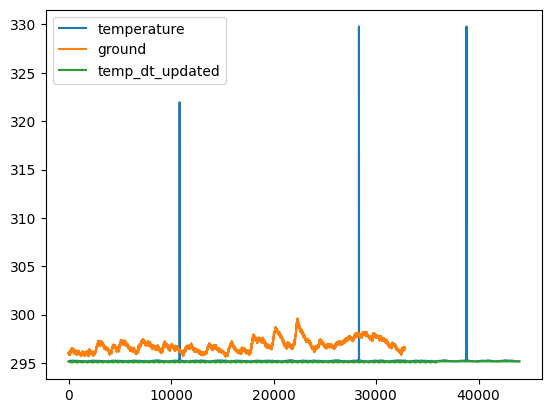

In [178]:
plt.plot(results['temperature'], label='temperature')
plt.plot(df['temperature'], label='ground')
plt.plot(temp_dt_updated[100:len(results['temperature'])], label='temp_dt_updated')
plt.legend()

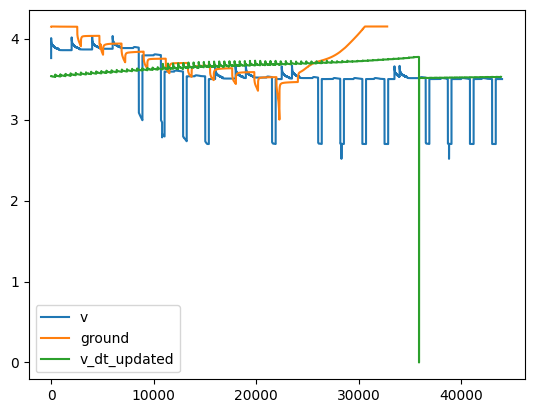

In [167]:
plt.plot(results['voltage'], label='v')
plt.plot(df['voltage'], label='ground')
plt.plot(v_dt_updated[100:len(results['voltage'])], label='v_dt_updated')
plt.legend()

/tmp/ipykernel_361/1328486979.py:35: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x_range_zoomed)


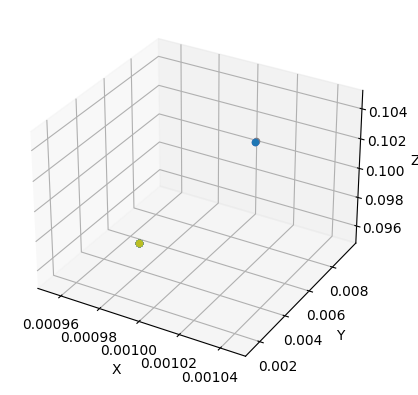

In [159]:
import matplotlib.pyplot as plt

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y']  # Different colors for each index

# Extract data from nominal_clusters
all_points = [point for data in nominal_clusters.values() for point in data[1::]]
all_x = [point[0] for point in all_points]
all_y = [point[1] for point in all_points]
all_z = [point[2] for point in all_points]

# Plot each cluster
for cluster, data in nominal_clusters.items():
    for i, point in enumerate(data[1::]):
         ax.scatter(point[0], point[1], point[2])

# Adjust the range for zooming
x_range = (min(all_x), max(all_x))
y_range = (min(all_y), max(all_y))
z_range = (min(all_z), max(all_z))

# Adjust the range by manually specifying the zoomed area
zoom_factor = 0.01  # Increase the zoom factor
x_range_zoomed = (x_range[0] + (x_range[1] - x_range[0]) * zoom_factor,
                  x_range[1] - (x_range[1] - x_range[0]) * zoom_factor)
y_range_zoomed = (y_range[0] + (y_range[1] - y_range[0]) * zoom_factor,
                  y_range[1] - (y_range[1] - y_range[0]) * zoom_factor)
z_range_zoomed = (z_range[0] + (z_range[1] - z_range[0]) * zoom_factor,
                  z_range[1] - (z_range[1] - z_range[0]) * zoom_factor)

# Set the axis limits for the zoomed area
ax.set_xlim(x_range_zoomed)
ax.set_ylim(y_range_zoomed)
ax.set_zlim(z_range_zoomed)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()